In [16]:
import os
import torch
import numpy as np
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from utils import tools, metrics
from modules.vae_base_module import VAEBaseModule
from models import supported_models
from datasets import supported_datamodules

plt.style.use('seaborn')
config_file = '../configs/vae/vae_simple_mnist.yaml'
log_path = '../logs/NoveltyMNISTDataModule/SimpleVAE/archive_v1_2021-04-21'
model_path = log_path + '/checkpoints/val_elbo_loss=0.37-epoch=29.ckpt'

In [17]:
config = tools.load_config(config_file)
exp_params = config['experiment-parameters']
data_params = config['data-parameters']
module_params = config['module-parameters']

datamodule = supported_datamodules[exp_params['datamodule']](**data_params)
datamodule.setup('test')

model = SimpleVAE(datamodule.data_shape, **module_params)

module = VAEBaseModule(model, **module_params)

checkpoint = torch.load(model_path)
module.load_state_dict(checkpoint['state_dict'])

Experimental parameters
------
{'data-parameters': {'batch_size': 128,
                     'root_data_path': '/home/brahste/Datasets/NoveltyMNIST',
                     'train_fraction': 0.9},
 'experiment-parameters': {'datamodule': 'NoveltyMNISTDataModule',
                           'log_dir': 'logs',
                           'model': 'SimpleVAE',
                           'patience': None},
 'module-parameters': {'latent_dims': 10, 'learning_rate': 0.01}}


<All keys matched successfully>

In [19]:
test_novelty_scores = []
test_novelty_labels = []

module.model.eval()
with torch.no_grad():
    for batch_nb, batch_tuple in enumerate(datamodule.test_dataloader()):
        result = module.test_step(batch_tuple, batch_nb);

        test_novelty_scores.extend(result['scores'].numpy())
        test_novelty_labels.extend(result['labels'].numpy())

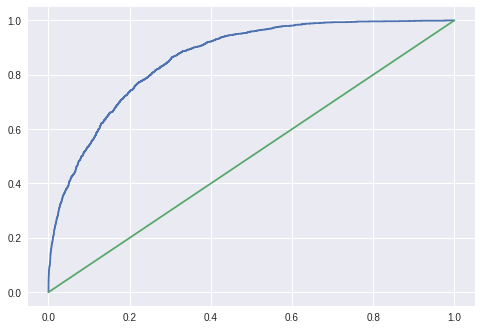

Model ROC AUC:  0.8612935813349035
Random ROC AUC: 0.5


In [20]:
fpr, tpr, thresholds, auc = metrics.roc(test_novelty_scores, test_novelty_labels)

plt.plot(fpr, tpr)
plt.plot([0., 1.], [0., 1.])
plt.show()
print('Model ROC AUC: ', auc)
print('Random ROC AUC: 0.5')

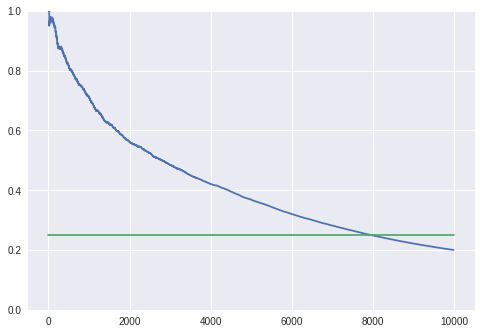

In [21]:
pak = metrics.precision_at_k(test_novelty_scores, test_novelty_labels)

uniques, counts = np.unique(test_novelty_labels, return_counts=True)
random = counts.min() / counts.max()

plt.plot(pak)
plt.plot([0, 10000], [random, random])
plt.ylim([0., 1.])
plt.show()

In [22]:
print(len(pak))

9984
